In [2]:
import numpy as np
import pandas as pd
import random

from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

distributed 1.21.8 requires msgpack, which is not installed.
axelrod 4.5.0 has requirement dask>=0.18.1, but you'll have dask 0.17.5 which is incompatible.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### India data

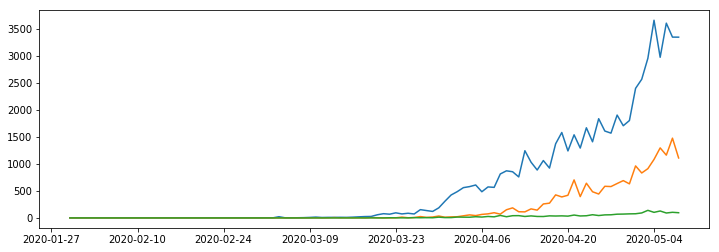

In [39]:
df = pd.read_csv("../data/09052020/case_time_series.csv")
df["Date"] = df["Date"] + " 2020"
df["Date"] = pd.to_datetime(df["Date"])
plt.figure(figsize=(12,4))
"""
plt.plot(df["Date"], np.log10(df["Daily Confirmed"]))
plt.plot(df["Date"], np.log10(df["Daily Recovered"]))
plt.plot(df["Date"], np.log10(df["Daily Deceased"]))
"""

plt.plot(df["Date"], df["Daily Confirmed"])
plt.plot(df["Date"], df["Daily Recovered"])
plt.plot(df["Date"], df["Daily Deceased"])


#df

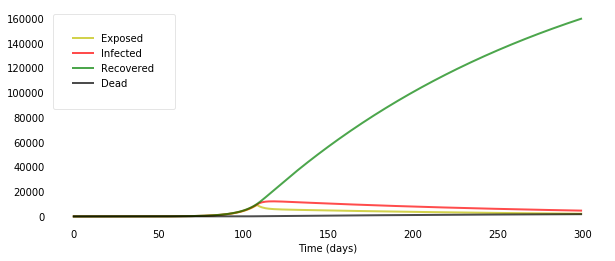

In [187]:
### Fitting to India data #####
############ SEIRD  Variable Ro and beta  #################
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

L = 108
N = 300e6 #1.3e9 #1_000_000
D = 3.0 #4 infections lasts four days (can spread to others for D days)
gamma = 1.0 / 10 #D  #(will recover in 10 days)
delta = 1.0 / 5.0  # incubation period of five days

### Variable Ro
def R_0(t):
    #return 4.5 if t < L else 2
    #return 2.2 if t < L else 2.0
    #return 2.8 if t < L else 0.80  # Good choice
    return 2.8 if t < L else 0.9

def beta(t):
    return R_0(t) * gamma

alpha = 0.033 #0.2  # 20% death rate (3.3% for India)
rho = 1/30  # 9 days from infection until death (30 days for India)
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

t = np.linspace(0, 299, 300) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

T = S + E + I + R + D
plotseird(t, S, E, I, R, D)

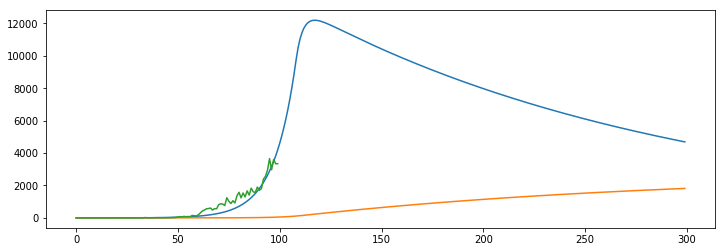

In [192]:
plt.figure(figsize=(12,4))
#plt.plot(df["Date"], df["Daily Recovered"])
#plt.plot(df["Date"], df["Daily Deceased"])
plt.plot(range(0, len(I)), I)
plt.plot(range(0, len(D)), D)
plt.plot(range(0,len(df)), df["Daily Confirmed"])

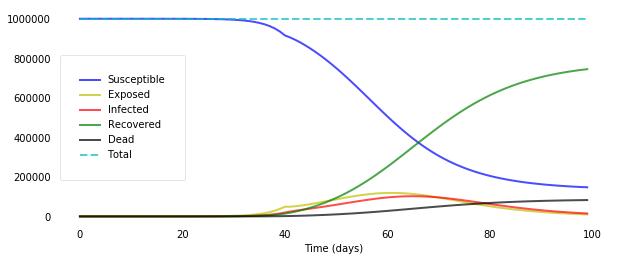

In [17]:
############ SEIRD  Variable Ro and beta  #################
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

L = 40
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days

### Variable Ro
def R_0(t):
    return 5.0 if t < L else 2
def beta(t):
    return R_0(t) * gamma

alpha = 0.2  # 20% death rate
rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

t = np.linspace(0, 99, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

plotseird(t, S, E, I, R, D)

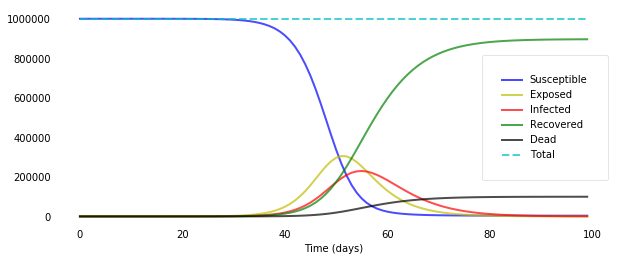

In [12]:
############ SEIRD #################

def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days

### Fixed Ro
R_0 = 5.0
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma

alpha = 0.2  # 20% death rate
rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

t = np.linspace(0, 99, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

plotseird(t, S, E, I, R, D)

In [11]:
############ SEIR #################
def deriv(y, t, N, beta, gamma, delta):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days
R_0 = 5.0
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
S0, E0, I0, R0 = N-1, 1, 0, 0  # initial conditions: one exposed


t = np.linspace(0, 99, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta))
S, E, I, R = ret.T

plotseird(t, S, E, I, R)

In [4]:
############## SIR ################
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


N = 1000
beta = 1.0  # infected person infects 1 other person per day
D = 4.0 # infections lasts four days
gamma = 1.0 / D

S0, I0, R0 = 999, 1, 0  # initial conditions: one infected, rest susceptible

t = np.linspace(0, 49, 50) # Grid of time points (in days)
y0 = S0, I0, R0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

plotsir(t, S, I, R)

In [32]:
def plotseird(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None):
    f, ax = plt.subplots(1,1,figsize=(10,4))
    #ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    if D is not None:
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
        #ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
    #else:
        #ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    if L is not None:
        plt.title("Lockdown after {} days".format(L))
    plt.show();

    if R0 is not None or CFR is not None:
        f = plt.figure(figsize=(12,4))

    if R0 is not None:
        # sp1
        ax1 = f.add_subplot(121)
        ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

        ax1.set_xlabel('Time (days)')
        ax1.title.set_text('R_0 over time')
        # ax.set_ylabel('Number (1000s)')
        # ax.set_ylim(0,1.2)
        ax1.yaxis.set_tick_params(length=0)
        ax1.xaxis.set_tick_params(length=0)
        ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax1.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

    if Alpha is not None:
        # sp2
        ax2 = f.add_subplot(122)
        ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

        ax2.set_xlabel('Time (days)')
        ax2.title.set_text('fatality rate over time')
        # ax.set_ylabel('Number (1000s)')
        # ax.set_ylim(0,1.2)
        ax2.yaxis.set_tick_params(length=0)
        ax2.xaxis.set_tick_params(length=0)
        ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax2.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

    plt.show();

In [10]:
def plotsir(t, S, I, R):
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();

In [55]:
# OD Matrix 
# size of matrix n x m
n = 3
m = 3
OD = [ [ random.randint(100,500) for i in range(n) ] for j in range(m) ]
OD = np.asmatrix(OD)

thresh = 200

# initialize parameters
beta = 1.6
gamma = 0.04
public_trans = 0.5  # alpha
R0 = beta/gamma
beta_vec = np.random.gamma(1.6, 2, locs_len)
gamma_vec = np.full(locs_len, gamma)
public_trans_vec = np.full(locs_len, public_trans)

In [65]:
n = 3
m = 3
OD = [ [ random.randint(100,500) for i in range(n) ] for j in range(m) ]
#OD = np.asmatrix(OD)
OD = np.asmatrix(OD)
OD

matrix([[251, 280, 182],
        [166, 484, 395],
        [185, 247, 449]])

In [66]:
N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
N_k

matrix([[140, 782, 762],
        [192, 450, 430],
        [ 28, 614, 594]])

In [67]:
len(N_k)

3

In [75]:
np.array([SIR_nsim[:,1],]*3).transpose()

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [56]:
N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
N_k = np.asarray(N_k.diagonal())[0]
locs_len = len(N_k)                 # number of locations
SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
SIR[:,0] = N_k                      # initialize the S group with the respective populations
SIR

first_infections = np.where(SIR[:, 0]<=thresh, SIR[:, 0]//20, 0)   # for demo purposes, randomly introduce infections
SIR[:, 0] = SIR[:, 0] - first_infections
SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group
SIR

# row normalize the SIR matrix for keeping track of group proportions
row_sums = SIR.sum(axis=1)
SIR_n = SIR / row_sums[:, np.newaxis]
SIR_n

# make copy of the SIR matrices 
SIR_sim = SIR.copy()
SIR_nsim = SIR_n.copy()

# run model
print(SIR_sim.sum(axis=0).sum() == N_k.sum())
from tqdm import tqdm_notebook
infected_pop_norm = []
susceptible_pop_norm = []
recovered_pop_norm = []

for time_step in tqdm_notebook(range(100)):
    infected_mat = np.array([SIR_nsim[:,1],]*locs_len).transpose()
    OD_infected = np.round(OD*infected_mat)
    inflow_infected = OD_infected.sum(axis=0)
    inflow_infected = np.round(inflow_infected*public_trans_vec)
    print('total infected inflow: ', inflow_infected.sum())
    new_infect = beta_vec*SIR_sim[:, 0]*inflow_infected/(N_k + OD.sum(axis=0))
    new_recovered = gamma_vec*SIR_sim[:, 1]
    new_infect = np.where(new_infect>SIR_sim[:, 0], SIR_sim[:, 0], new_infect)
    SIR_sim[:, 0] = SIR_sim[:, 0] - new_infect
    SIR_sim[:, 1] = SIR_sim[:, 1] + new_infect - new_recovered
    SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
    SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
    # recompute the normalized SIR matrix
    row_sums = SIR_sim.sum(axis=1)
    SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
    S = SIR_sim[:,0].sum()/N_k.sum()
    I = SIR_sim[:,1].sum()/N_k.sum()
    R = SIR_sim[:,2].sum()/N_k.sum()
    print(S, I, R, (S+I+R)*N_k.sum(), N_k.sum())
    print('\n')
    infected_pop_norm.append(I)
    susceptible_pop_norm.append(S)
    recovered_pop_norm.append(R)

True


ValueError: shapes (1,3) and (1,3) not aligned: 3 (dim 1) != 1 (dim 0)

In [59]:
infected_mat

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [58]:
SIR_nsim[:,1]

array([0., 0., 0.])

In [57]:
SIR

array([[209.,   0.,   0.],
       [211.,   0.,   0.],
       [281.,   0.,   0.]])

In [60]:
OD_infected = np.round(OD*infected_mat)
OD_infected

matrix([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [61]:
public_trans_vec

array([0.5, 0.5, 0.5])

In [ ]:
# initialize the population vector from the origin-destination flow matrix
N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
locs_len = len(N_k)                 # number of locations
SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
SIR[:,0] = N_k                      # initialize the S group with the respective populations

first_infections = np.where(SIR[:, 0]<=thresh, SIR[:, 0]//20, 0)   # for demo purposes, randomly introduce infections
SIR[:, 0] = SIR[:, 0] - first_infections
SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group

# row normalize the SIR matrix for keeping track of group proportions
row_sums = SIR.sum(axis=1)
SIR_n = SIR / row_sums[:, np.newaxis]

# initialize parameters
beta = 1.6
gamma = 0.04
public_trans = 0.5                                 # alpha
R0 = beta/gamma
beta_vec = np.random.gamma(1.6, 2, locs_len)
gamma_vec = np.full(locs_len, gamma)
public_trans_vec = np.full(locs_len, public_trans)

# make copy of the SIR matrices 
SIR_sim = SIR.copy()
SIR_nsim = SIR_n.copy()

# run model
print(SIR_sim.sum(axis=0).sum() == N_k.sum())
from tqdm import tqdm_notebook
infected_pop_norm = []
susceptible_pop_norm = []
recovered_pop_norm = []
for time_step in tqdm_notebook(range(100)):
    infected_mat = np.array([SIR_nsim[:,1],]*locs_len).transpose()
    OD_infected = np.round(OD*infected_mat)
    inflow_infected = OD_infected.sum(axis=0)
    inflow_infected = np.round(inflow_infected*public_trans_vec)
    print('total infected inflow: ', inflow_infected.sum())
    new_infect = beta_vec*SIR_sim[:, 0]*inflow_infected/(N_k + OD.sum(axis=0))
    new_recovered = gamma_vec*SIR_sim[:, 1]
    new_infect = np.where(new_infect>SIR_sim[:, 0], SIR_sim[:, 0], new_infect)
    SIR_sim[:, 0] = SIR_sim[:, 0] - new_infect
    SIR_sim[:, 1] = SIR_sim[:, 1] + new_infect - new_recovered
    SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
    SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
    # recompute the normalized SIR matrix
    row_sums = SIR_sim.sum(axis=1)
    SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
    S = SIR_sim[:,0].sum()/N_k.sum()
    I = SIR_sim[:,1].sum()/N_k.sum()
    R = SIR_sim[:,2].sum()/N_k.sum()
    print(S, I, R, (S+I+R)*N_k.sum(), N_k.sum())
    print('\n')
    infected_pop_norm.append(I)
    susceptible_pop_norm.append(S)
    recovered_pop_norm.append(R)